In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# 1. Preprocessing and EDA (Exploratory Data Analysis)

In [2]:
train_dir = "../data/fer-2013-data/train"
for dirpath,dirname,filenames in os.walk(train_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in train
There are 0 directories and 3995 images in train\angry
There are 0 directories and 436 images in train\disgust
There are 0 directories and 4097 images in train\fear
There are 0 directories and 7215 images in train\happy
There are 0 directories and 4965 images in train\neutral
There are 0 directories and 4830 images in train\sad
There are 0 directories and 3171 images in train\surprise


In [3]:
test_dir = "../data/fer-2013-data/test"
for dirpath,dirname,filenames in os.walk(test_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in test
There are 0 directories and 958 images in test\angry
There are 0 directories and 111 images in test\disgust
There are 0 directories and 1024 images in test\fear
There are 0 directories and 1774 images in test\happy
There are 0 directories and 1233 images in test\neutral
There are 0 directories and 1247 images in test\sad
There are 0 directories and 831 images in test\surprise


In [4]:
data_gen = ImageDataGenerator(rescale=1./255)
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)
validation_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


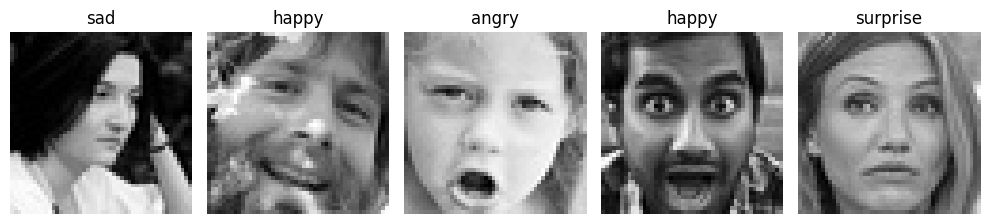

In [5]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

def plot_images(images_arr, labels_arr, label_map):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        class_label = label_map[np.argmax(label)]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(class_label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(train_generator)
plot_images(images[:5], labels[:5], label_map)

# 2. Traditional Image Processing/Enhancement

In [47]:
# Image enhancement for low level vision: image inpainting
# Image Inpainting is a task of reconstructing missing regions in an image.
def image_inpainting(image, inpaint_radius=3, block_size=9, C=7):
    # Read the grayscale image
    if image is None:
        raise ValueError("The image could not be loaded.")

    # Use adaptive thresholding to create a mask of the text
    # This helps to handle varying lighting conditions and textures in the image
    mask = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C)
    
    # Use dilation followed by erosion to connect parts of the text in the mask (closing)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Inpaint the original image using the mask
    inpainted_image = cv2.inpaint(image, mask, inpaint_radius, cv2.INPAINT_TELEA)
    
    return inpainted_image

# Image enhancement for low level vision: image resizing
def image_resizing(image, dimensions=(48,48), interpolation=cv2.INTER_LINEAR):
    # image: the image to resize.
    # dimensions: the new image dimensions as a tuple (width, height).
    # interpolation: method of interpolation.
    resized_image = cv2.resize(image, dimensions, interpolation=interpolation)
    return resized_image

# Histogram equalization to enhance features of images
def histogram_equalization(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Reduce noise by median blur
def reduce_noise_median(image):
    denoised_image = cv2.medianBlur(image, 3)
    return denoised_image

# Reduce noise by gaussian filter
def reduce_noise_gaussian(image):
    denoised_image = cv2.GaussianBlur(image, (3, 3), 0)
    return denoised_image

# Reduce noise: firstly, gaussian filter secondly, median blur
def smooth_image_first_gaussian(image):
    image = reduce_noise_gaussian(image)
    image = reduce_noise_median(image)
    return image

# Reduce noise: firstly, median blur secondly, Gaussian filter
def smooth_image_first_median(image):
    image = reduce_noise_median(image)
    image = reduce_noise_gaussian(image)
    return image

In [34]:
# this function will gives us singularity for image showing
# using opencv for reading, matplotlib for displaying
def show_image_as_plot(image_path, 
                    image_inpainting_val=False, 
                    image_resizing_val=False, 
                    histogram_equalization_val=False, 
                    reduce_noise_median_val=False,
                    reduce_noise_gaussian_val=False,
                    smooth_image_first_gaussian_val=False,
                    smooth_image_first_median_val=False
                    ):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if image_inpainting_val:
        image = image_inpainting(image)
        
    if image_resizing_val:
        image = image_resizing(image)
        
    if histogram_equalization_val:
        image = histogram_equalization(image)
    
    if reduce_noise_gaussian_val:
        image = reduce_noise_gaussian(image)
        
    if reduce_noise_median_val:
        image = reduce_noise_median(image)
    
    if smooth_image_first_gaussian_val:
        image = smooth_image_first_gaussian(image)

    if smooth_image_first_median_val:
        image = smooth_image_first_median(image)
        
    #plt.imshow(image_rgb)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

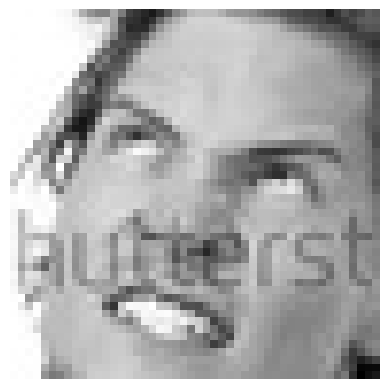

In [39]:
# this is an example image to show our enhancements on images
#improvable_image_path = "../data/fer-2013-data/train/angry/Training_2861857.jpg"
improvable_image_path = "../data/fer-2013-data/train/angry/Training_6640570.jpg"
show_image_as_plot(improvable_image_path)

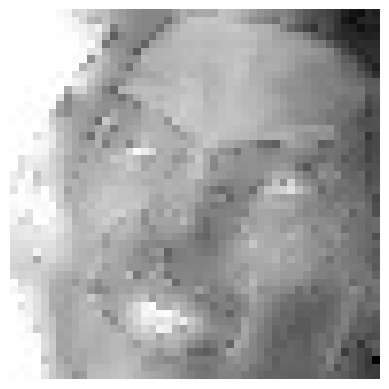

In [42]:
show_image_as_plot(improvable_image_path, image_inpainting_val=True)

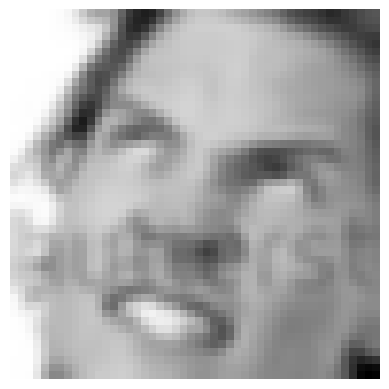

In [43]:
show_image_as_plot(improvable_image_path, reduce_noise_gaussian_val=True)

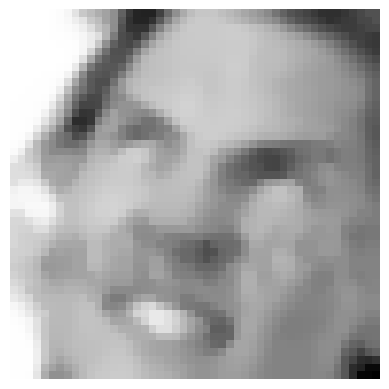

In [44]:
show_image_as_plot(improvable_image_path, smooth_image_first_gaussian_val=True)

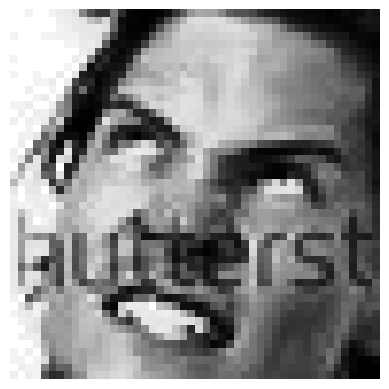

In [45]:
show_image_as_plot(improvable_image_path, histogram_equalization_val=True)